In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

[Karsten Keller. Entropy_Measures_for_Data_Analysis. Entropy 2019, 21, 935, doi:10.3390/e21100935](https://www.mdpi.com/books/pdfview/book/1906)


[data used below](https://github.com/llorenzo62/Entropy/tree/master/Permutation_entropy)

Starting with the definition Permutation Entropy [PE] from [David Cuesta-Frau, Juan Pablo Murillo-Escobar, Diana Alexandra Orrego and Edilson Delgado-Trejos. Embedded  Dimension and Time Series Length. Practical Influence on Permutation Entropy and Its Applications Entropy  2019, 21, 385; doi:10.3390/e21040385](https://www.mdpi.com/books/pdfview/book/1906)

> 
2.1. Permutation Entropy
    Given an input time series $\{ x_t : t = 0, ... , N − 1 \}$ , and an embedding dimension $m > 1$, for each extracted subsequence at time $s, ( s ) \leftarrow x_{s −( m − 1 )} , x_{s −( m − 2 )} , ..., x_{s − 1} , x_{s}$ , an ordinal pattern π related to s is obtained as $\pi = ( r_0 , r_1 , ..., r_{m − 1} )$ , defined by $x_{s − r_{m − 1}} ≤ x_{ s − r_{ m − 2}} ≤ . . . ≤ x_{ s − r_1} ≤ x_{ s − r_{ 0}}$ [15]. For all the possible $m!$ permutations, each probability $p ( π )$ is estimated as the relative frequency of each different $π$ pattern found. Once all these probabilities have been obtained, the final value of PE is given by [11]:   $$PE = -\sum_{j=0}^{m!-1}{p(\pi_j)\log(p(\pi_j))}, \text{ if } p(\pi_j)>0$$
   More details of the PE algorithm, including examples, can be found in [11]. 
The implicit input parameters for PE are:
   * The embedded dimension m. The recommended range for this parameter is 3, . . . , 7 [11], but other greater values have been used successfully [12,24,26,27]. 
   * The embedded delay τ. The influence of the embedded delay has been studied in several previous publications [10,29] for specific applications .... this parameter contributes to a reduction in the amount of data available when τ > 1 in practical terms [30], and therefore might have a detrimental effect on the analysis. 
   * The length of the time series N. As stated before, the recommended relationship m! << N is commonplace in practically all the publications related to PE, ....


_python3_ allows a especially concise implementation of PE

In [2]:
#The PE algorithm
def PE(serie,m,tau=1,okfr=False,oktie='order'):
    '''
    serie: time serie. list, np.array or compatible
    m: embedded dimension
    tau: embedded delay
    okfr: if True outpus pattern's empirical distribution as a dictionary
    oktie: tie treatment. 
        'equal' same rank for all elements
        'order' assign rank by order or aparition
        'drop' drops out patterns with ties
        
    '''
    freq={}
   
    serie=list(serie)
    
    if tau>1:
        ser=[]
        for t in range(tau):
            ser+=serie[t::tau]
        serie=ser
    
    
    if oktie=='order':
        for index in range(m,len(serie)+1):
            #encoding
            y=[(val,key) for key,val in enumerate(serie[index-m:index])]
            key=[-1]*len(y)
            for index,item in enumerate(sorted(y)):
                key[item[1]]=index
            key=tuple(key)
            #counting
            freq[key]=freq.get(key,0)+1
    else:
        for index in range(m,len(serie)+1):
            #encoding
            s={val:indx for indx,val in enumerate(sorted(serie[index-m:index]))}
            key=tuple(s[item] for item in serie[index-m:index])
            #counting
            freq[key]=freq.get(key,0)+1
    
    freq={key:val for key,val in freq.items() if len(key)==m} #Drop out malformed patterns
    
    if oktie=='drop': #drop out ties
        freq={key:val for key,val in freq.items() if len(key)==len(set(key))}
        
    #Compute PE
    f=np.array(list(freq.values()))
    f=f/f.sum()
    if okfr:
        return (-f*np.log(f)).sum(), freq
    return (-f*np.log(f)).sum()   

In [3]:
#Some useful suff

#Batch simulations
def simulation(series,name_serie,rN,rm,rb):
    
    import time
    import pandas as pd
    
    res=[]
    for nn in rN:
        for name,serie in zip(name_serie,series):
            serie=serie[:int(round(nn))]
            for m in rm:
                for b in rb:
                    time0=time.time()
                    res.append((name,len(serie),b,m,PE(serie,m,b,oktie=False),len(serie)/np.math.factorial(m),time.time()-time0))

        print(res[-1])
    res_m=np.array(res)
    lms=pd.DataFrame(res_m,columns=['serie','N','b','m','PE','N/m!','t'])
    lms['b']=lms['b'].astype(np.integer)
    lms['m']=lms['m'].astype(np.integer)
    lms['PE']=lms['PE'].astype(np.float)
    lms['N/m!']=lms['N/m!'].astype(np.float)
    lms['t']=lms['t'].astype(np.float)
    lms['H']=np.log(lms['m'].apply(np.math.factorial))-lms['PE']
    lms['N']=(lms['N']).astype(np.integer)
    return lms

def select(sec,data):
    res=data.copy()
    for col,cond in sec:
        res=res[res[col] == cond]
    return res
        

In [4]:
x = [6,9,11,12,8,13,5]
s,fr=PE(x,3,1,okfr=True)
print(s,PE(x,3,1)/np.log(2))
print(fr)

1.0549201679861442 1.5219280948873626
{(0, 1, 2): 2, (1, 2, 0): 2, (1, 0, 2): 1}


## Simulations

### synthetic time series  

_Lorenz_ from   Teddy Craciunescu, Andrea Murari and Michela Gelfusa. Entropy 2018, 20, 891; doi:10.3390/e20110891  
_LMS_ from Albert B. Piek, Inga Stolz and Karsten Keller Entropy 2019, 21, 547; doi:10.3390/e21060547


In [5]:
def logistic(n,C=3.6):
    L=[np.random.uniform(0,1)]
    for _ in range(n):
        L.append(C*L[-1]*(1-L[-1]))
    return L 

def LMS(n,p=8):
    a=np.random.random()
    a=np.ceil(2**p*a)*2**(-p)
    L=[np.sin(2*np.pi*a)]
    for _ in range(n):
        b=np.random.uniform(0.5,7)
        a=(2*a % 1)+b*2**(-p)
        L.append(np.sin(2*np.pi*a))
    return L

def Lorenz(v,dt=0.01,C=2):
    x1,x2,x3,y1,y2,y3=v
    
    dx1=10*(x2-x1)
    dx2=x1*(28-x3)-x2
    dx3=x1*x2-8*x3/3
    dy1=10*(y2-y1)
    dy2=y1*(28.001-y3)-y2
    dy3=y1*y2-8*y3/3+C*(x3-y3)
    
    return [x1+dx1*dt, x2+dx2*dt, x3+dx3*dt, y1+dy1*dt, y2+dy2*dt, y3+dy3*dt]
        

In [ ]:
N=100000

v=np.random.random(6)
for _ in range(100):
    v=Lorenz(v)
    
x1,x2,x3,y1,y2,y3=v
series=[[x1],[x2],[x3],[y1],[y2],[y3]]
for _ in range(N):
    v=Lorenz(v)
    x1,x2,x3,y1,y2,y3=v
    series[0].append(x1)
    series[1].append(x2)
    series[2].append(x3)
    series[3].append(y1)
    series[4].append(y2)
    series[5].append(y3)

name_serie=['Lorenz{}'.format(indx) for indx in range(len(serie))]
    

In [ ]:
N=1000000

series=[]
name_serie=[]
for val in [60,70,80]:

    series.append(LMS(N,val))
    name_serie.append('LMS{}'.format(val))

    

In [ ]:
N=1000000
series=[]


#sin waves
from random import sample

p=np.array([7,11])#vector with periods for sin wave
c=np.array([2,2])#vector with coefficients for sin wave
c0=1.0 #random error coeff.
lp=[]
for i in range(N):
    lp.append((c*np.sin(np.pi*2*i/p)).sum()+c0*(np.random.normal()-0.5))
series.append(lp)

p=np.array([7,11])#vector with periods for sin wave
c=np.array([2,2])#vector with coefficients for sin wave
c0=0.0
lp=[]
for i in range(N):
    lp.append((c*np.sin(np.pi*2*i/p)).sum()+c0*(np.random.normal()-0.5))
series.append(lp)
name_serie=['sin7_11','sin7_11_e']

In [6]:
%%time
N=int(round(1e6))
series=[np.random.normal(0,1,N)]
#sin waves
from random import sample

p=np.array([7,11,103])#vector with periods for sin wave
c=np.array([2,2,2])#vector with coefficients for sin wave
c0=1.0 #random error coeff.
lp=[]
for i in range(N):
    lp.append((c*np.sin(np.pi*2*i/p)).sum()+c0*(np.random.normal()-0.5))
series.append(lp)

p=np.array([7,11,103])#vector with periods for sin wave
c=np.array([2,2,2])#vector with coefficients for sin wave
c0=0.0
lp=[]
for i in range(N):
    lp.append((c*np.sin(np.pi*2*i/p)).sum()+c0*(np.random.normal()-0.5))
series.append(lp)
lp=[]
v=np.random.random(6)
for i in range(N):
    v=Lorenz(v)
    
    lp.append(v[0])
series.append(lp)


series.append(LMS(N,60))
series.append(LMS(N,120))
series.append(logistic(N))

name_serie=['uniform','sin7_11_e','sin7_11','Lorenz','LMS60','LMS120','logistic']

CPU times: user 24.8 s, sys: 86.3 ms, total: 24.9 s
Wall time: 24.9 s


Let define _simulation(series,name_serie,rN,rm,rb)_ where:
* series: a list of time series generated as above.
* name_serie: string identify each time serie
* rN: list with N values to be tested
* rm: list with m values to be tested
* rb: list with $\tau$ values to be tested  

This function returns a _pandas.DataFrame_ with the columns:
* serie: string identify the time serie
* N: len(time serie)
* b: $\tau$ value used in $PE_{m,\tau}$
* m: m value used in $PE_{m,\tau}$
* PE: $PE_{m,\tau}(time serie)$
* N/m!
* H or PE_r: $\log(m!)-PE_{m,\tau}$
* t: Runtime in seconds


In [8]:
%%time
ts=np.exp(np.linspace(np.log(100),np.log(N),50))
exper5_Nmb=simulation(series,name_serie,ts,range(3,10),range(1,20))

('logistic', 100, 19, 9, 4.3861728243307905, 0.0002755731922398589, 0.00025081634521484375)
('logistic', 121, 19, 9, 4.580170718416422, 0.0003334435626102293, 0.00034689903259277344)
('logistic', 146, 19, 9, 4.927253685157205, 0.000402336860670194, 0.0003407001495361328)
('logistic', 176, 19, 9, 5.057949962207074, 0.0004850088183421517, 0.0004246234893798828)
('logistic', 212, 19, 9, 5.27055106968814, 0.0005842151675485009, 0.0005092620849609375)
('logistic', 256, 19, 9, 5.474299469843048, 0.0007054673721340388, 0.000606536865234375)
('logistic', 309, 19, 9, 5.674870861001901, 0.000851521164021164, 0.0007262229919433594)
('logistic', 373, 19, 9, 5.865714752897345, 0.0010278880070546737, 0.0008907318115234375)
('logistic', 450, 19, 9, 6.037990868188471, 0.001240079365079365, 0.00104522705078125)
('logistic', 543, 19, 9, 6.186392183603603, 0.0014963624338624338, 0.0012600421905517578)
('logistic', 655, 19, 9, 6.364405079354442, 0.0018050044091710757, 0.0015168190002441406)
('logistic', 7

import pickle
with open('exper5_Nmb.pkl','wb') as fich:
    pickle.dump(exper5_Nmb,fich)

In [10]:
import pickle
with open('exper5_Nmb.pkl','rb') as fich:
    lms = pickle.load(fich)


## Runtime  

$N$, $m$ and $\tau$ effect  on $PE_{m,\tau}(serie)$ runtime 



In [11]:
lms.describe()

,N,b,m,PE,N/m!,t,H
count,46550.000000,46550.000000,46550.000000,46550.000000,46550.000000,46550.000000,4.655000e+04
mean,116705.640000,10.000000,6.000000,4.599052,3639.240735,0.221133,2.296398e+00
std,224069.341553,5.477284,2.000021,2.431464,16016.274838,0.442128,2.434096e+00
min,100.000000,1.000000,3.000000,0.703478,0.000276,0.000129,1.648614e-08
25%,954.000000,5.000000,4.000000,2.782242,0.355556,0.001722,2.455242e-01
50%,10044.000000,10.000000,6.000000,4.408763,11.763083,0.017845,1.386159e+00
75%,104811.000000,15.000000,8.000000,6.085558,308.750000,0.190870,3.765943e+00
max,1000000.000000,19.000000,9.000000,12.602443,166666.666667,3.039598,1.149541e+01


In [12]:
lms.serie.unique()

array(['uniform', 'sin7_11_e', 'sin7_11', 'Lorenz', 'LMS60', 'LMS120',
       'logistic'], dtype=object)

In [13]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()

### Runtime vs. N

<IPython.core.display.Javascript object>


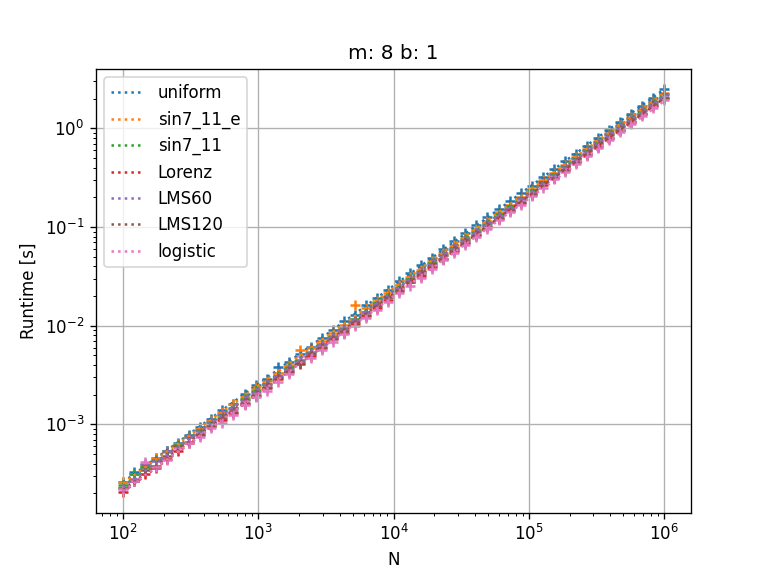

uniform; score: 0.9999445579943333
	 log(Runtime) [s]= [0.99528268] log(N) + -12.838538179899677
sin7_11_e; score: 0.9997258453445493
	 log(Runtime) [s]= [0.98823578] log(N) + -12.830037421624125
sin7_11; score: 0.9998737926560071
	 log(Runtime) [s]= [0.99104816] log(N) + -12.909438732037659
Lorenz; score: 0.9999508377840454
	 log(Runtime) [s]= [0.99671424] log(N) + -13.069275731077765
LMS60; score: 0.9998255230367973
	 log(Runtime) [s]= [0.99038384] log(N) + -12.92380386699254
LMS120; score: 0.999907596737277
	 log(Runtime) [s]= [0.99224893] log(N) + -12.999999305194427
logistic; score: 0.9994675023352468
	 log(Runtime) [s]= [0.98809594] log(N) + -13.015018532133109


In [14]:
for serie in lms.serie.unique():
    m=8
    b=1
    sec=select([('serie',serie),('m',m),('b',b)],lms)
    
    X=sec['N'].apply(np.log)
    y=sec['t'].apply(np.log)
    #color=['red','green','blue'][int(m/4)-1]
    model.fit(np.array(X).reshape(-1,1),y)
    plt.plot(np.exp(X),np.exp(model.predict(np.array(X).reshape(-1,1))),linestyle='dotted')
    plt.scatter(np.exp(X),np.exp(y),marker='+')
    print('{}; score: {}\n\t log(Runtime) [s]= {} log(N) + {}'.format(serie,model.score(np.array(X).reshape(-1,1),y)
                                                ,model.coef_,model.intercept_))
plt.xlabel('N')
plt.xscale('log')
plt.ylabel('Runtime [s]')
plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('m: {} b: {}'.format(m,b))

plt.grid()

plt.show()




### Runtime vs m

<IPython.core.display.Javascript object>


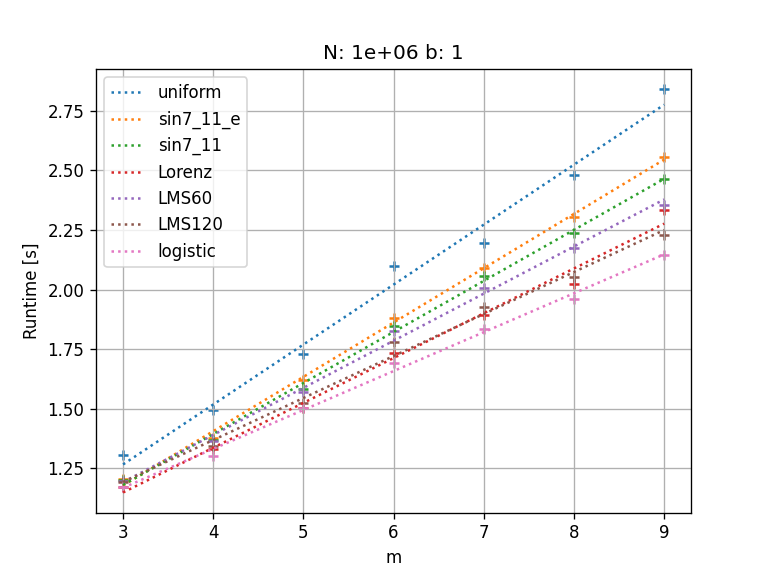

uniform; score: 0.9878603948434332
	 Runtime [s]= [0.25143749] m + 0.5124971185411731
sin7_11_e; score: 0.998334225016932
	 Runtime [s]= [0.22777695] m + 0.49530713898795
sin7_11; score: 0.9977019135019146
	 Runtime [s]= [0.21401445] m + 0.5384292432240079
Lorenz; score: 0.9913651594919285
	 Runtime [s]= [0.18790276] m + 0.585484198161534
LMS60; score: 0.9965700043954998
	 Runtime [s]= [0.19755168] m + 0.6002818175724578
LMS120; score: 0.9925885062451402
	 Runtime [s]= [0.17614871] m + 0.6646533182689127
logistic; score: 0.9958463868362929
	 Runtime [s]= [0.1631363] m + 0.6795677968433924


In [16]:
for serie in lms.serie.unique():
   
    b=1
    sec=select([('serie',serie),('b',b)],lms)
    sec=sec[sec['N']>0.9*sec.N.max()]
    X=sec['m']
    y=sec['t']
    #color=['red','green','blue'][int(m/4)-1]
    model.fit(np.array(X).reshape(-1,1),y)
    plt.plot((X),(model.predict(np.array(X).reshape(-1,1))),linestyle='dotted')
    plt.scatter((X),(y),marker='+')
    print('{}; score: {}\n\t Runtime [s]= {} m + {}'.format(serie,model.score(np.array(X).reshape(-1,1),y)
                                                ,model.coef_,model.intercept_))
plt.xlabel('m')
#plt.xscale('log')
plt.ylabel('Runtime [s]')
#plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('N: {:g} b: {}'.format(sec.N.max(),b))

plt.grid()

plt.show()


### Runtime vs $\tau$

### $\tau$ effect  
A _delay_ operation on serie $S_N=\{ s_0, ..., s_N\}$ splits it in $\tau$ series of length $\frac{N}{\tau}$,  $\sigma_i=\{s_i,s_{i+\tau},s_{i+2\tau}..., s_{i+\frac{N}{\tau}}\}$. Define a new time serie $S_{N,\tau}=\cup_{i=0}^{\tau-1}\sigma_i$ and then we could define the $PE$ with dimension $m$ and delay $\tau$ on $S_N$ as $$PE_{m,\tau}(S_N) \equiv PE_{m,1}(S_{N,\tau})$$  



<IPython.core.display.Javascript object>


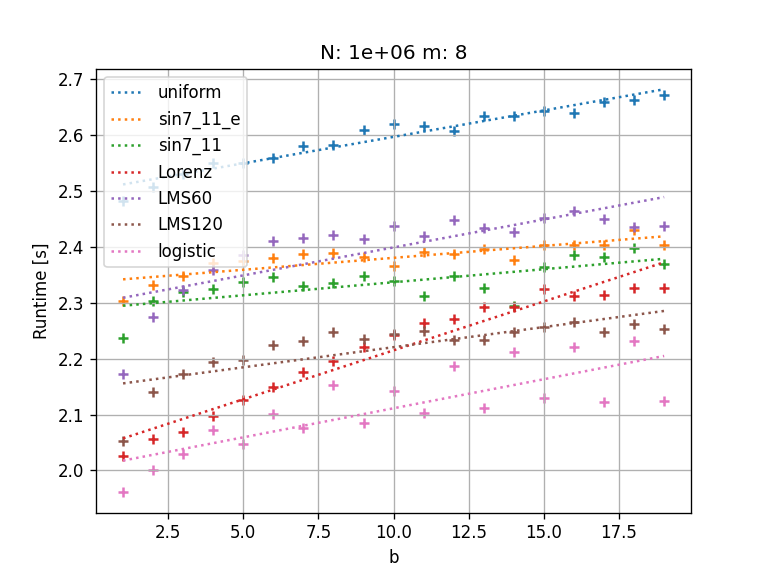

uniform; score: 0.9446890541297901
	 Runtime [s]= [0.00946428] b + 2.5024913193886738
sin7_11_e; score: 0.6945489788034312
	 Runtime [s]= [0.00427794] b + 2.3378177860326934
sin7_11; score: 0.5108442578452832
	 Runtime [s]= [0.00466828] b + 2.2901993383441055
Lorenz; score: 0.9457812319682765
	 Runtime [s]= [0.01751334] b + 2.0398536899633575
LMS60; score: 0.6069899714491226
	 Runtime [s]= [0.010012] b + 2.299104222080164
LMS120; score: 0.6087156620419774
	 Runtime [s]= [0.00720542] b + 2.148592003604822
logistic; score: 0.6460990100030927
	 Runtime [s]= [0.01040353] b + 2.0072455406188965


In [17]:
for serie in lms.serie.unique():
   
    m=8
    sec=select([('serie',serie),('m',m)],lms)
    sec=sec[sec['N']>0.9*sec.N.max()]
    X=sec['b']
    y=sec['t']
    #color=['red','green','blue'][int(m/4)-1]
    model.fit(np.array(X).reshape(-1,1),y)
    plt.plot((X),(model.predict(np.array(X).reshape(-1,1))),linestyle='dotted')
    plt.scatter((X),(y),marker='+')
    print('{}; score: {}\n\t Runtime [s]= {} b + {}'.format(serie,
                                                                      model.score(np.array(X).reshape(-1,1),y)
                                                                    ,model.coef_,model.intercept_))
plt.xlabel('b')
#plt.xscale('log')
plt.ylabel('Runtime [s]')
#plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('N: {:g} m: {}'.format(sec.N.max(),m))

plt.grid()

plt.show()


 
How good estimations are could be seen in a $PE_{m,\tau}$ vs. $\log(\frac{N}{m!})$ graph for uniform. The expected value of $PE_{m,\tau} = \log(m!)$ for each $m$ value is represented as a dotted segment

<IPython.core.display.Javascript object>


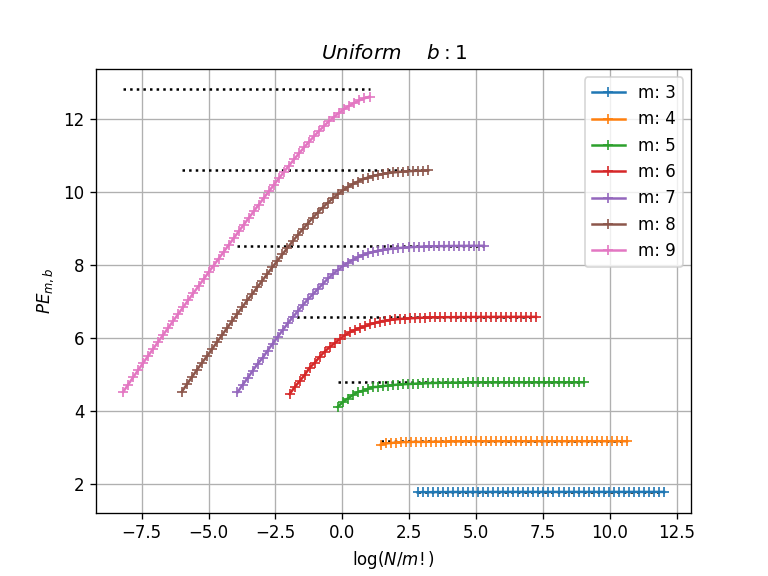

In [18]:

for m in range(round(lms.m.min()),round(lms.m.max())+1):
   
    
    sec=select([('serie','uniform'),('b',1),('m',m)],lms)
    
    X=sec['N/m!'].apply(np.log)
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    plt.hlines(np.log(np.math.factorial(m)),X.min(),X.max(), linestyles='dotted')
    
plt.xlabel('$\log(N/m!)$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(['m: {}'.format(item) for item in range(round(lms.m.min()),round(lms.m.max())+1)])
plt.title('$ Uniform ~~~~   b: %i $' % b)

plt.grid()

plt.show()




It is clear that $\log(\frac{N}{m!})>0$ for a reliable estimation. 

If we represent the estimation relative error, computed as $\frac{\log(m!)-PE_{m,\tau}}{PE_{m,\tau}}$ v.s.  $\log(\frac{N}{m!})$ we could see that $N \approx m!$ corresponds to a relative error $\frac{\log(m!)-PE_{m,\tau}}{PE_{m,\tau}} \approx 10\%$. The red dotted line represents this 10% relative error.

<IPython.core.display.Javascript object>


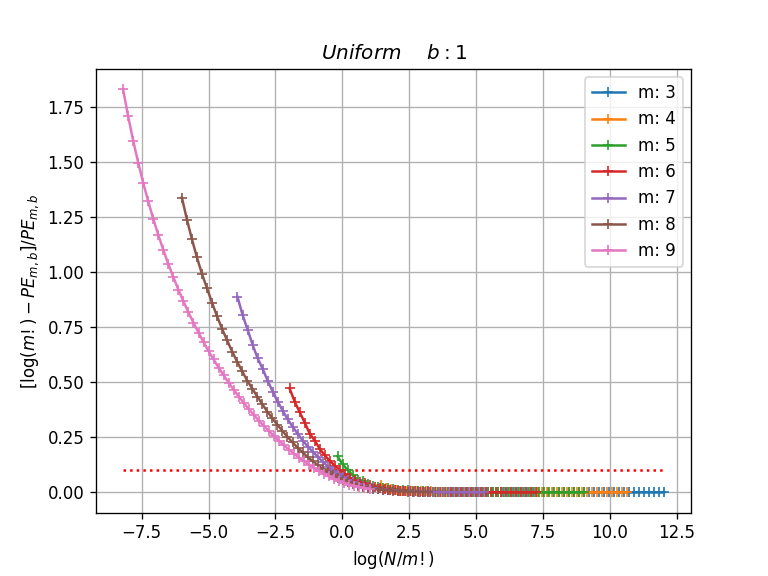

In [19]:
mn=float('inf')
mx=-float('inf')
for m in range(round(lms.m.min()),round(lms.m.max())+1):
   
    
    sec=select([('serie','uniform'),('b',1),('m',m)],lms)
    
    X=sec['N/m!'].apply(np.log)
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['H']/sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    

plt.hlines(0.1,mn,mx, linestyles='dotted',color='red')
plt.xlabel('$\log(N/m!)$')
#plt.xscale('log')
plt.ylabel('$[\log(m!)-PE_{m,b}]/PE_{m,b}$')
#plt.yscale('log')
plt.legend(['m: {}'.format(item) for item in range(round(lms.m.min()),round(lms.m.max())+1)])
plt.title('$ Uniform ~~~~   b: %i $' % b)

plt.grid()

plt.show()




<IPython.core.display.Javascript object>


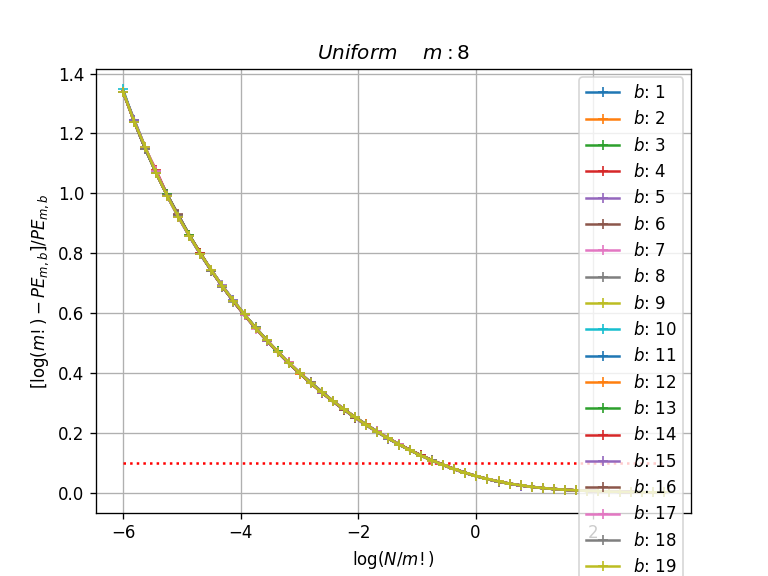

In [20]:
mn=float('inf')
mx=-float('inf')
m=8
for b in range(round(lms.b.min()),round(lms.b.max())+1):
   
    
    sec=select([('serie','uniform'),('b',b),('m',m)],lms)
    
    X=sec['N/m!'].apply(np.log)
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['H']/sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    

plt.hlines(0.1,mn,mx, linestyles='dotted',color='red')
plt.xlabel('$\log(N/m!)$')
#plt.xscale('log')
plt.ylabel('$[\log(m!)-PE_{m,b}]/PE_{m,b}$')
#plt.yscale('log')
plt.legend(['$b$: {}'.format(item) for item in range(round(lms.b.min()),round(lms.b.max())+1)])
plt.title('$ Uniform ~~~~   m: %i $' % m)

plt.grid()

plt.show()




<IPython.core.display.Javascript object>


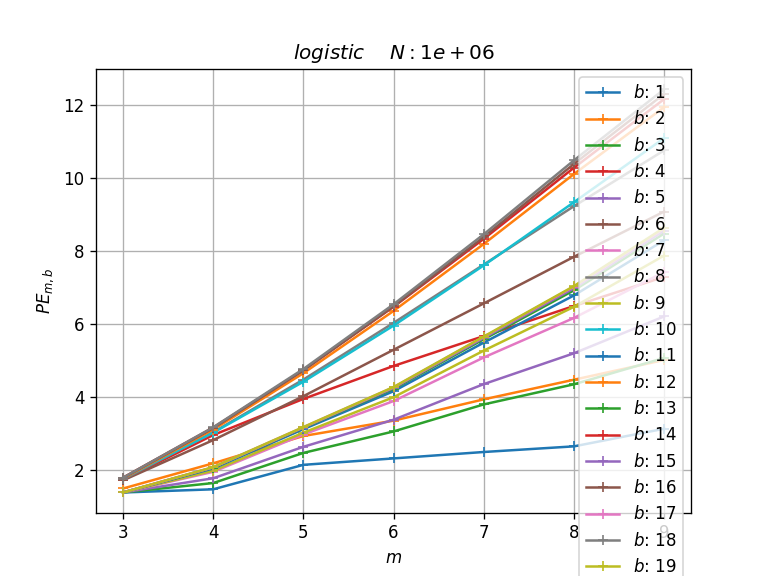

In [21]:
mn=float('inf')
mx=-float('inf')
serie=lms.serie.unique()[-1]
for b in range(round(lms.b.min()),round(lms.b.max())+1):
   
    
    sec=select([('serie',serie),('b',b)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['m']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    

    

plt.xlabel('$m$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(['$b$: {}'.format(item) for item in range(round(lms.b.min()),round(lms.b.max())+1)])
plt.title('$ %s ~~~~   N: %g $' % (serie,round(sec['N'].max())))

plt.grid()

plt.show()




<IPython.core.display.Javascript object>


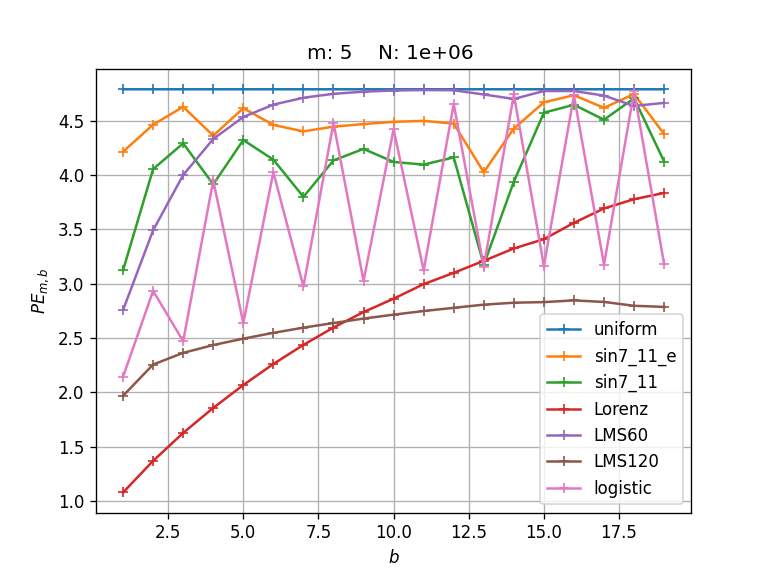

In [22]:
mn=float('inf')
mx=-float('inf')
m=5
for serie in lms.serie.unique():
    
   
    
    sec=select([('serie',serie),('m',m)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['b']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$b$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('m: %i    N: %g ' % (m,round(sec['N'].max())))

plt.grid()

plt.show()




In [24]:
exper8_b=simulation(series,name_serie,[1e6],[3,5,7,8,9],range(1,101))

('logistic', 1000000, 100, 9, 12.55466493629008, 2.755731922398589, 2.602465867996216)


In [25]:
with open('exper8_b.pkl','wb') as fich:
    pickle.dump(exper8_b,fich)

In [26]:
with open('exper8_b.pkl','rb') as fich:
    lms = pickle.load(fich)

In [27]:
lms.serie.unique()

array(['uniform', 'sin7_11_e', 'sin7_11', 'Lorenz', 'LMS60', 'LMS120',
       'logistic'], dtype=object)

In [28]:
lms.describe()

,N,b,m,PE,N/m!,t,H
count,3500.0,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,1000000.0,50.500000,6.400000,6.041386,35045.194004,2.067661,1.660782
std,0.0,28.870195,2.154374,3.352758,65897.856884,0.500305,2.139791
min,1000000.0,1.000000,3.000000,0.819778,2.755732,1.167403,-0.000007
25%,1000000.0,25.750000,5.000000,3.178951,24.801587,1.680930,0.035118
50%,1000000.0,50.500000,7.000000,5.307849,198.412698,2.164271,0.533519
75%,1000000.0,75.250000,8.000000,8.522643,8333.333333,2.440185,2.454082
max,1000000.0,100.000000,9.000000,12.602895,166666.666667,3.266938,11.174193


<IPython.core.display.Javascript object>


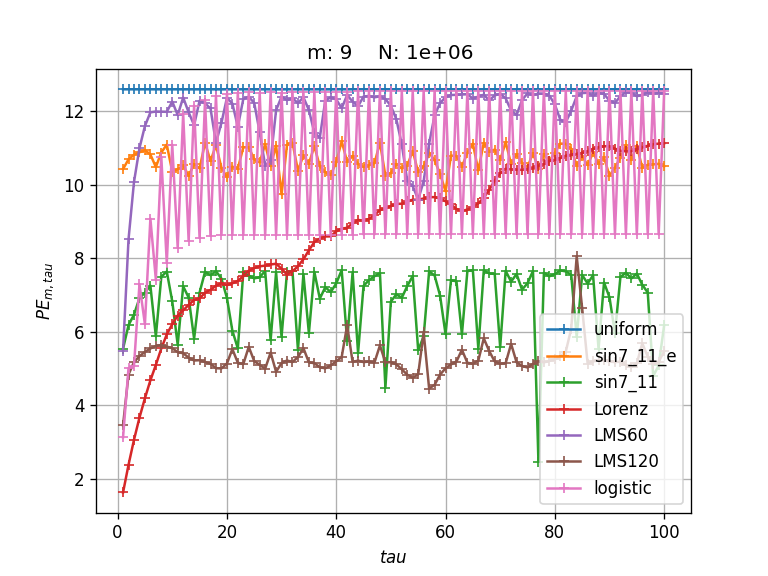

In [39]:
mn=float('inf')
mx=-float('inf')
m=9
for serie in lms.serie.unique():
    
   
    
    sec=select([('serie',serie),('m',m)],lms)
    sec=sec[sec['N']>0.9*lms.N.max()]
    X=sec['b']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$tau$')
#plt.xscale('log')
plt.ylabel('$PE_{m,tau}$')
#plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('m: %i    N: %g ' % (m,N))

plt.grid()

plt.show()



<IPython.core.display.Javascript object>


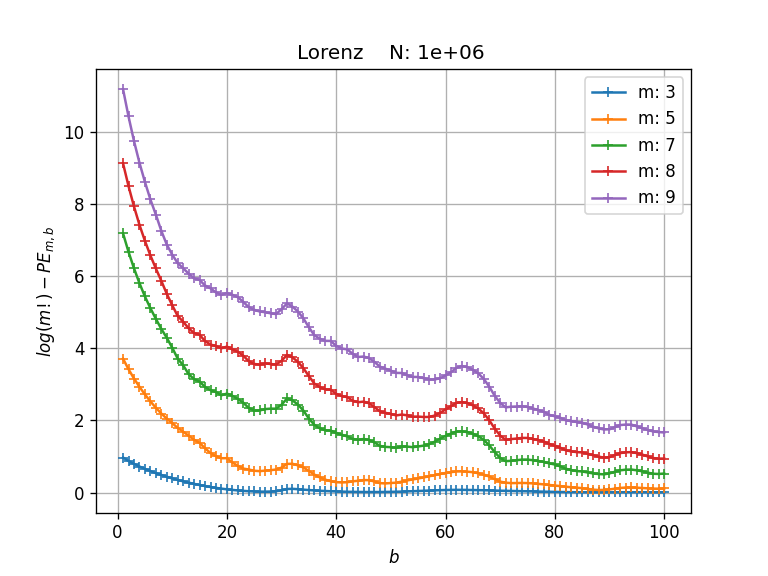

In [37]:
mn=float('inf')
mx=-float('inf')
serie=lms.serie.unique()[3]
for m in lms.m.unique():
    
   
    
    sec=select([('serie',serie),('m',m)],lms)
    #sec=sec[sec['N']>9.9e5]
    X=sec['b']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=np.log(np.math.factorial(m))-sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$b$')
#plt.xscale('log')
plt.ylabel('$log(m!)-PE_{m,b}$')
#plt.yscale('log')
plt.legend(['m: {}'.format(item) for item in lms.m.unique()])
plt.title('%s    N: %g ' % (serie,round(sec['N'].max())))

plt.grid()

plt.show()

